# Running a default CNN model on MNIST dataset to benchmark it's accuracy


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,random_split
from torchvision import datasets, transforms
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import time
import torchvision
import random
import copy
import cv2
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
torch.manual_seed(0)
np.random.seed(0)

In [2]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cn1 = nn.Conv2d(1, 16, 3, 1)
        self.cn2 = nn.Conv2d(16, 32, 3, 1)
        self.dp1 = nn.Dropout2d(0.10)
        self.dp2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(4608, 64) # 4608 is basically 12 X 12 X 32
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.cn1(x)
        x = F.relu(x)
        x = self.cn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dp1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        op = F.log_softmax(x, dim=1)
        return op

In [3]:
def train(train_dataloader, model = None, epochs=1):
    torch.manual_seed(0)
    device = torch.device("cpu")
    optimizer = torch.optim.Adadelta(model.parameters(), lr=0.1)
    model.train()
    for epoch in range(epochs):
        for b_i, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)
            loss = F.nll_loss(pred_prob, y) # nll is the negative likelihood loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if b_i % 10 == 0:
                print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                    epoch, b_i, len(train_dataloader),
                    100. * b_i / len(train_dataloader), loss.item()))
    return model

def test(model):
    model.eval()
    loss = 0
    success = 0
    targets = []
    outputs = []
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X, y
            pred_prob = model(X)
            loss += F.nll_loss(pred_prob, y, reduction='sum').item()  # loss summed across the batch
            pred = pred_prob.argmax(dim=1, keepdim=True)  # use argmax to get the most likely prediction
            success += pred.eq(y.view_as(pred)).sum().item()
            outputs.append(pred.view(-1))
            targets.append(y)

    loss /= len(test_dataloader.dataset)

    accuracy = 100. * success / len(test_dataloader.dataset)

    print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss, success, len(test_dataloader.dataset), accuracy))
    outputs = torch.cat(outputs,0).detach().cpu().numpy()
    targets = torch.cat(targets,0).detach().cpu().numpy()
    cf = confusion_matrix(outputs, targets, labels=np.array(range(10)))

    return accuracy, cf

from sklearn.metrics import confusion_matrix
import seaborn as sns
def get_class_percentages(cm):
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    percentages = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                percentages[i, j] = ''
            else:
                percentages[i, j] = '%.1f%%' % p
    return percentages

## Orignal Mnist Dataset Class distribution

100%|██████████| 9912422/9912422 [00:00<00:00, 88223197.68it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 101966072.24it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 26556886.99it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16062840.45it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})
Distribution of classes in original dataset:


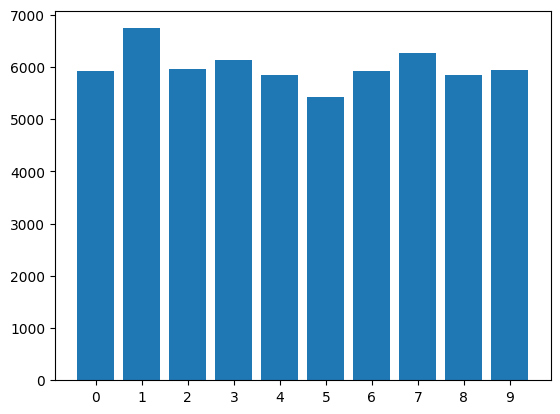

In [4]:
trainset = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1302,), (0.3069,))]))
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
print(Counter(train_dataloader.dataset.targets.numpy()))

print('Distribution of classes in original dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(train_dataloader.dataset.targets, return_counts=True)
ax.bar(range(10), counts)
ax.set_xticks(range(10))
plt.show()

In [5]:
test_ds = datasets.MNIST('../data', train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,))]))

test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=500, shuffle=True)

# Balanced/Orignal Dataset Training

In [6]:
model = train(train_dataloader, ConvNet(), epochs=1)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 0 [0/469 (0%)]	 training loss: 2.307978
epoch: 0 [10/469 (2%)]	 training loss: 2.176277
epoch: 0 [20/469 (4%)]	 training loss: 1.791520
epoch: 0 [30/469 (6%)]	 training loss: 1.259994
epoch: 0 [40/469 (9%)]	 training loss: 0.858351
epoch: 0 [50/469 (11%)]	 training loss: 0.811457
epoch: 0 [60/469 (13%)]	 training loss: 0.663700
epoch: 0 [70/469 (15%)]	 training loss: 0.876886
epoch: 0 [80/469 (17%)]	 training loss: 0.548574
epoch: 0 [90/469 (19%)]	 training loss: 0.586028
epoch: 0 [100/469 (21%)]	 training loss: 0.509902
epoch: 0 [110/469 (23%)]	 training loss: 0.621910
epoch: 0 [120/469 (26%)]	 training loss: 0.445612
epoch: 0 [130/469 (28%)]	 training loss: 0.378437
epoch: 0 [140/469 (30%)]	 training loss: 0.429885
epoch: 0 [150/469 (32%)]	 training loss: 0.586058
epoch: 0 [160/469 (34%)]	 training loss: 0.439508
epoch: 0 [170/469 (36%)]	 training loss: 0.247928
epoch: 0 [180/469 (38%)]	 training loss: 0.439258
epoch: 0 [190/469 (41%)]	 training loss: 0.517592
epoch: 0 [200/46

# Test Model

In [7]:
print("On vanilla MNIST dataset")
test_acc, cf = test(model)
print("test accuracy : ", str(test_acc))
percentages0 = get_class_percentages(cf)

On vanilla MNIST dataset

Test dataset: Overall Loss: 0.1825, Overall Accuracy: 9447/10000 (94%)

test accuracy :  94.47


# Performance of the Model on Imbalanced MNIST Dataset

### Create Imbalanced Dataset

In [8]:
# generate imbalanced dataset
torch.manual_seed(0)
num_classes = 10
sample_probs = torch.rand(num_classes)

idx_to_remove = [idx for idx, target in enumerate(train_dataloader.dataset.targets)
              if random.random() > sample_probs[target] #or target in range(3, 10)
              ]
imbalanced_train_dataset = copy.deepcopy(trainset)
imbalanced_train_dataset.targets = np.delete(train_dataloader.dataset.
                                            targets, idx_to_remove, axis=0)
imbalanced_train_dataset.data = np.delete(train_dataloader.dataset.data,
                                            idx_to_remove, axis=0)
imbalanced_train_loader = torch.utils.data.DataLoader(
                        imbalanced_train_dataset, batch_size=100, shuffle=True)

Distribution of classes in Imbalanced dataset:
Counter({7: 5639, 1: 5154, 9: 3714, 5: 3453, 0: 2963, 6: 2932, 8: 2697, 4: 1785, 3: 877, 2: 526})


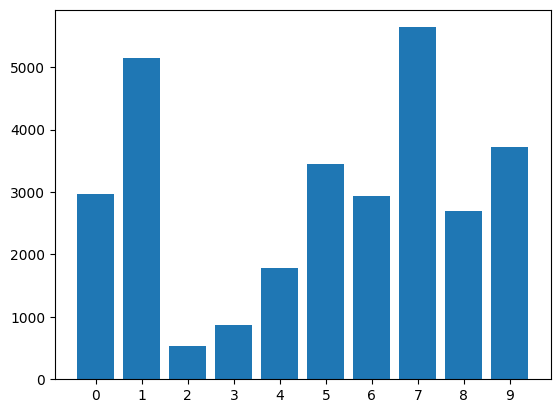

In [9]:
print('Distribution of classes in Imbalanced dataset:')
print(Counter(imbalanced_train_loader.dataset.targets.numpy()))
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_train_loader.dataset.targets, return_counts=True)
ax.bar(range(10), counts)
ax.set_xticks(range(10))
plt.show()

### train model on imbalanced dataset

In [10]:
imbalanced_model = train(imbalanced_train_loader, ConvNet(), epochs=1)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 0 [0/298 (0%)]	 training loss: 2.293511
epoch: 0 [10/298 (3%)]	 training loss: 1.951050
epoch: 0 [20/298 (7%)]	 training loss: 1.273082
epoch: 0 [30/298 (10%)]	 training loss: 0.983383
epoch: 0 [40/298 (13%)]	 training loss: 0.969471
epoch: 0 [50/298 (17%)]	 training loss: 0.574878
epoch: 0 [60/298 (20%)]	 training loss: 0.532873
epoch: 0 [70/298 (23%)]	 training loss: 0.477306
epoch: 0 [80/298 (27%)]	 training loss: 0.597524
epoch: 0 [90/298 (30%)]	 training loss: 0.456462
epoch: 0 [100/298 (34%)]	 training loss: 0.304089
epoch: 0 [110/298 (37%)]	 training loss: 0.450008
epoch: 0 [120/298 (40%)]	 training loss: 0.414967
epoch: 0 [130/298 (44%)]	 training loss: 0.353392
epoch: 0 [140/298 (47%)]	 training loss: 0.612715
epoch: 0 [150/298 (50%)]	 training loss: 0.327094
epoch: 0 [160/298 (54%)]	 training loss: 0.290361
epoch: 0 [170/298 (57%)]	 training loss: 0.240130
epoch: 0 [180/298 (60%)]	 training loss: 0.277583
epoch: 0 [190/298 (64%)]	 training loss: 0.344082
epoch: 0 [200/

### test on test set

In [11]:
print("performance on MNIST testset")
test_acc, cf = test(imbalanced_model)
print("test accuracy : ", str(test_acc))
percentages1 = get_class_percentages(cf)

performance on MNIST testset

Test dataset: Overall Loss: 0.2675, Overall Accuracy: 9175/10000 (92%)

test accuracy :  91.75


# Balance the above create imbalanced dataset using VAE
Example references:
1. https://github.com/alexmanuele/Creating-Synthetic-Data-with-VAE/blob/master/using_VAE_to_improve_classification_performance.ipynb

2. https://medium.com/dataseries/variational-autoencoder-with-pytorch-2d359cbf027b

3. you can use your own references too

# Loading Mnist data

In [12]:
train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

imbalanced_train_dataset.transform = train_transform
test_ds.transform = test_transform

m=len(imbalanced_train_dataset)

train_data, val_data = random_split(imbalanced_train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size,shuffle=True)

# Model definition

In [13]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc #.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale #.cuda()
        self.kl = 0

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [14]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [15]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

In [16]:
### Set the random seed for reproducible results
torch.manual_seed(0)

d = 4

vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

Selected device: cpu


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=288, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=4, bias=True)
    (linear3): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchN

# Training and Testing functions

In [17]:
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    count=0
    for x, _ in dataloader:
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = vae(x)
        # print(x.shape, x_hat.shape)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        if count%60==0:
            print("Iteration ", count)
            print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()
        count+=1

    return train_loss / len(dataloader.dataset)

def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

# Visualization Module

In [18]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_ds.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][np.random.randint(500, size=1)[0]] for i in range(n)}
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        img = test_ds[t_idx[i]][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img))
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n-1:
            ax.set_title('Reconstructed images')
            plt.show()

# Start Visual Auto Encoder Training

Iteration  0
	 partial train loss (single batch): 69836.406250
Iteration  60
	 partial train loss (single batch): 42324.875000

 EPOCH 1/50 	 train loss 185.163 	 val loss 137.004


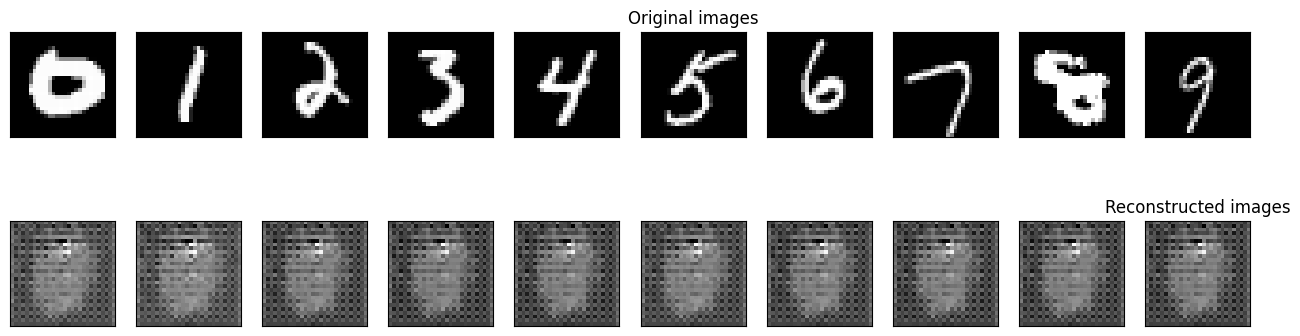

Iteration  0
	 partial train loss (single batch): 34612.488281
Iteration  60
	 partial train loss (single batch): 23653.376953

 EPOCH 2/50 	 train loss 102.396 	 val loss 77.641


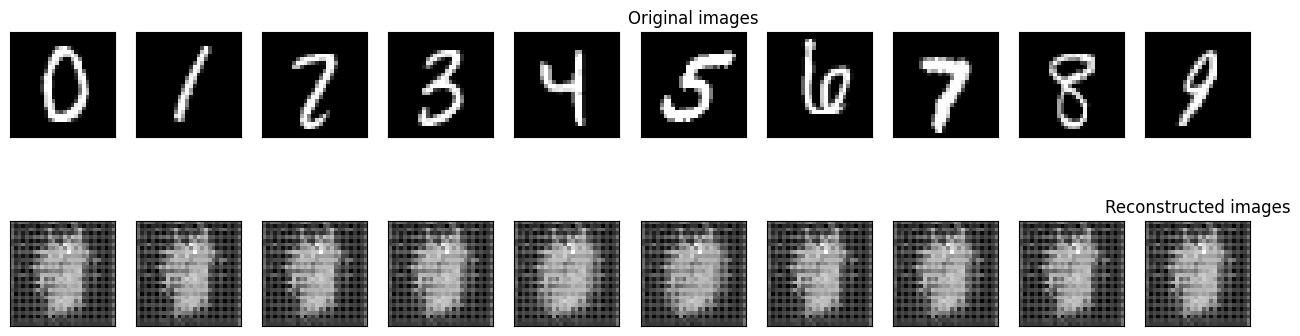

Iteration  0
	 partial train loss (single batch): 19751.207031
Iteration  60
	 partial train loss (single batch): 16297.093750

 EPOCH 3/50 	 train loss 66.355 	 val loss 58.298


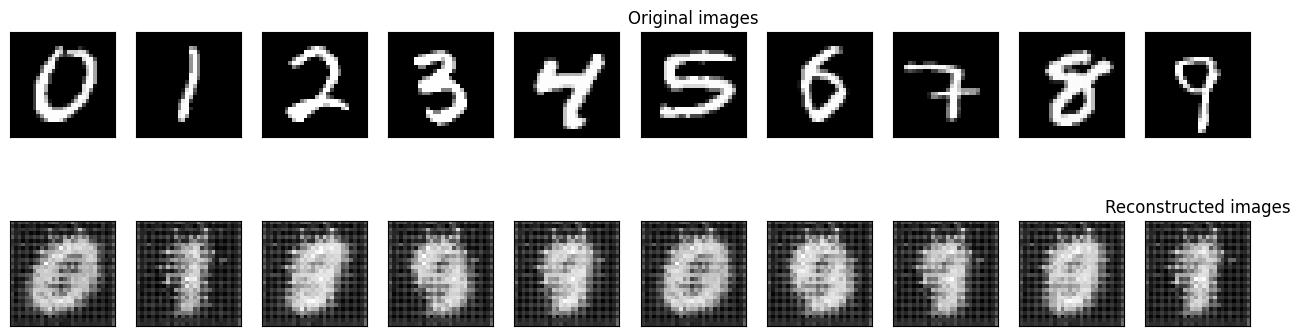

Iteration  0
	 partial train loss (single batch): 14799.821289
Iteration  60
	 partial train loss (single batch): 13197.740234

 EPOCH 4/50 	 train loss 52.775 	 val loss 47.711


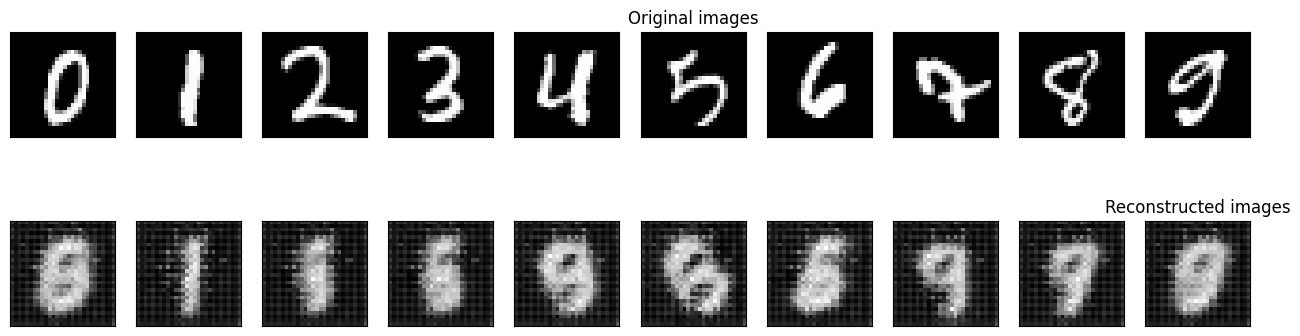

Iteration  0
	 partial train loss (single batch): 12262.800781
Iteration  60
	 partial train loss (single batch): 11401.303711

 EPOCH 5/50 	 train loss 44.841 	 val loss 41.927


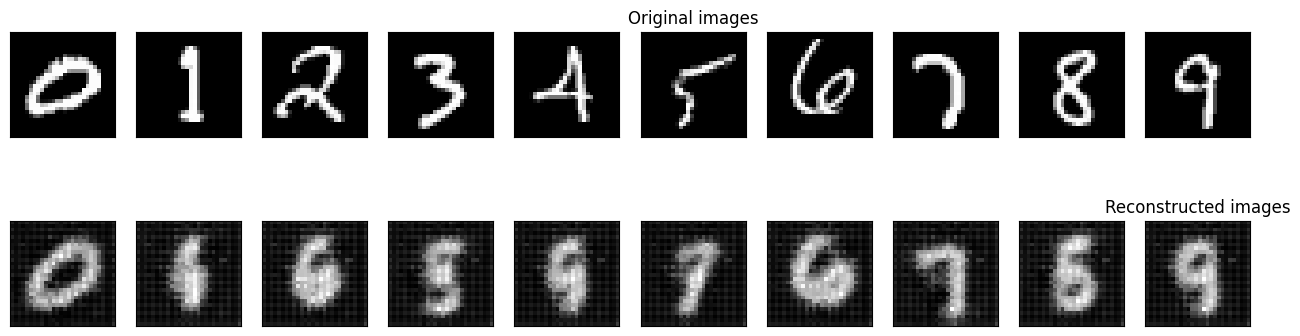

Iteration  0
	 partial train loss (single batch): 10716.396484
Iteration  60
	 partial train loss (single batch): 10113.179688

 EPOCH 6/50 	 train loss 39.676 	 val loss 38.085


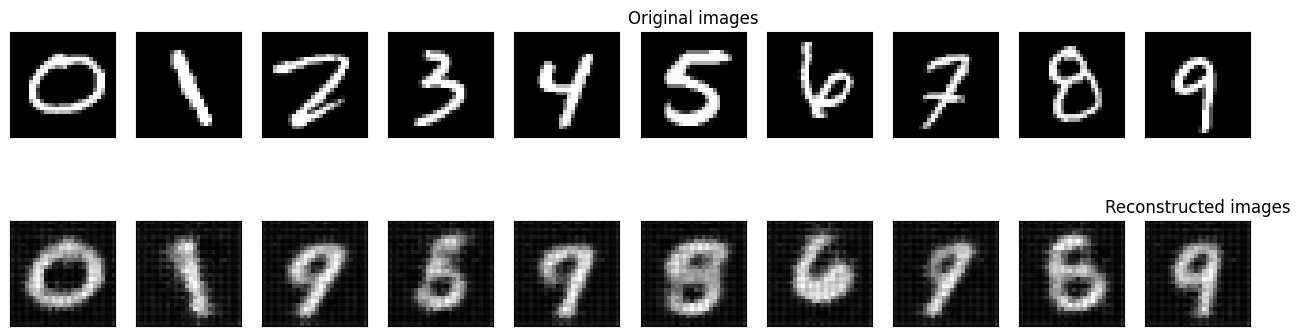

Iteration  0
	 partial train loss (single batch): 9814.757812
Iteration  60
	 partial train loss (single batch): 9563.769531

 EPOCH 7/50 	 train loss 36.895 	 val loss 36.139


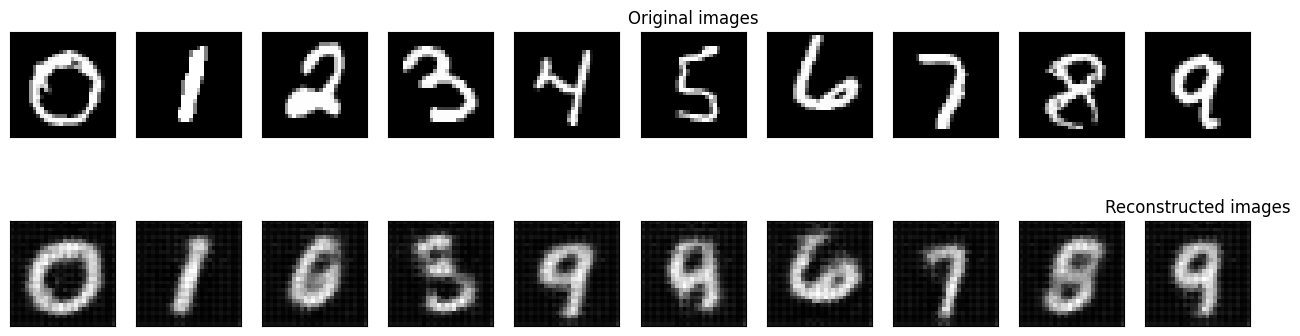

Iteration  0
	 partial train loss (single batch): 9358.911133
Iteration  60
	 partial train loss (single batch): 9097.917969

 EPOCH 8/50 	 train loss 35.359 	 val loss 34.974


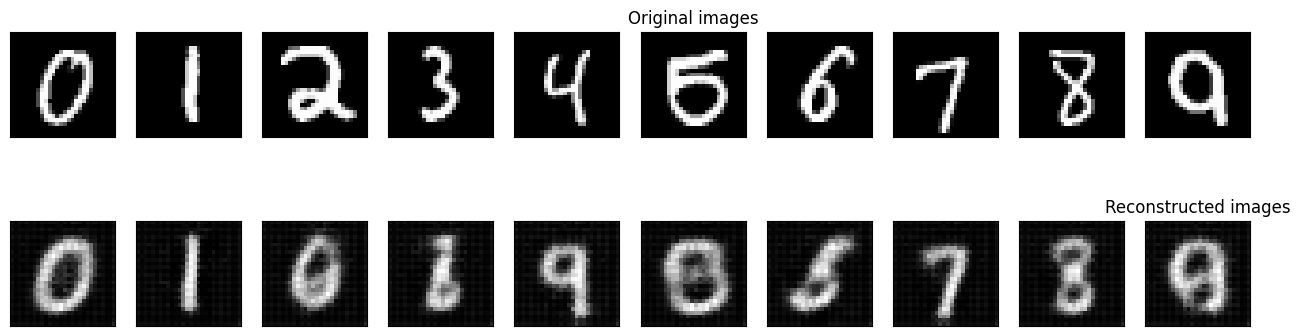

Iteration  0
	 partial train loss (single batch): 9065.063477
Iteration  60
	 partial train loss (single batch): 8865.519531

 EPOCH 9/50 	 train loss 34.375 	 val loss 34.005


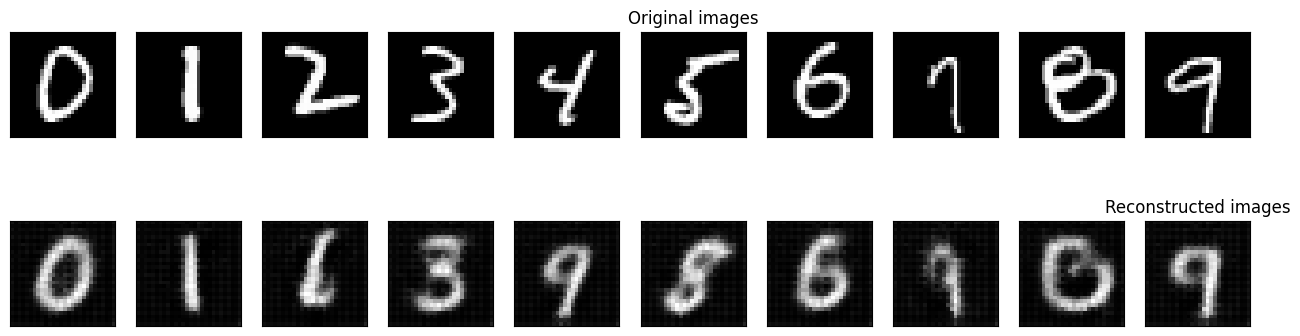

Iteration  0
	 partial train loss (single batch): 8853.794922
Iteration  60
	 partial train loss (single batch): 8659.233398

 EPOCH 10/50 	 train loss 33.702 	 val loss 33.515


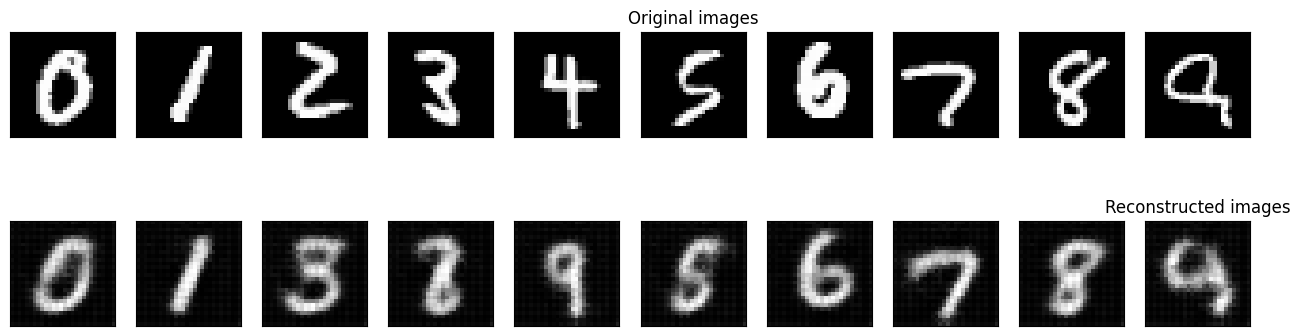

Iteration  0
	 partial train loss (single batch): 8744.716797
Iteration  60
	 partial train loss (single batch): 8624.044922

 EPOCH 11/50 	 train loss 33.149 	 val loss 32.991


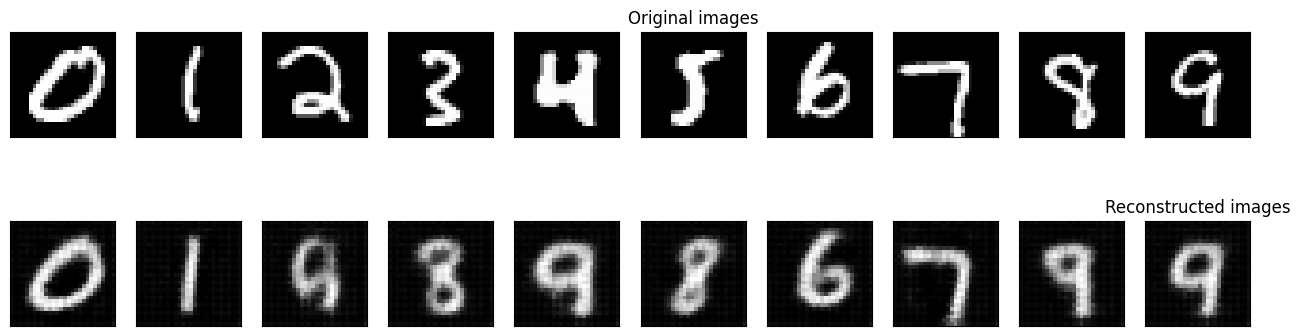

Iteration  0
	 partial train loss (single batch): 8554.478516
Iteration  60
	 partial train loss (single batch): 8478.405273

 EPOCH 12/50 	 train loss 32.688 	 val loss 32.855


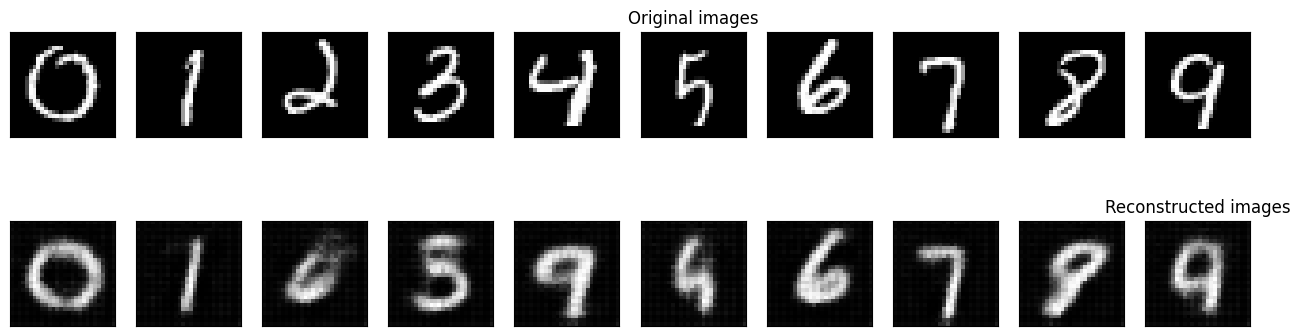

Iteration  0
	 partial train loss (single batch): 8500.387695
Iteration  60
	 partial train loss (single batch): 8405.574219

 EPOCH 13/50 	 train loss 32.392 	 val loss 32.397


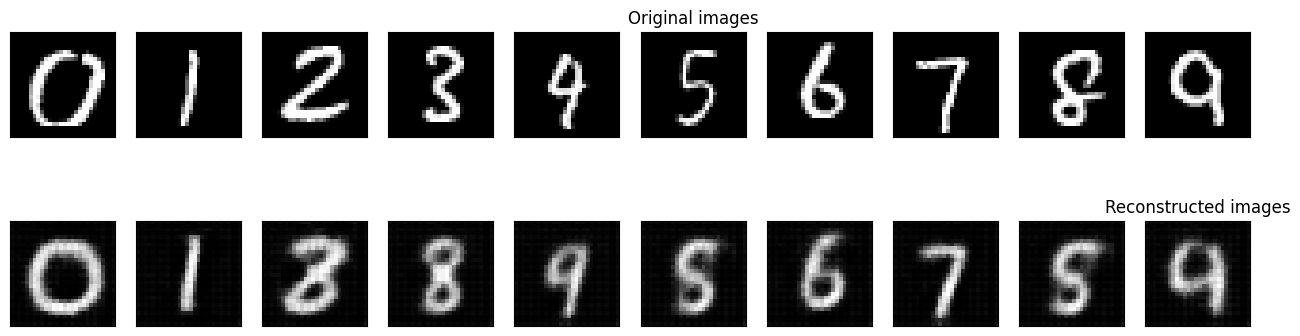

Iteration  0
	 partial train loss (single batch): 8385.643555
Iteration  60
	 partial train loss (single batch): 8339.349609

 EPOCH 14/50 	 train loss 32.099 	 val loss 32.176


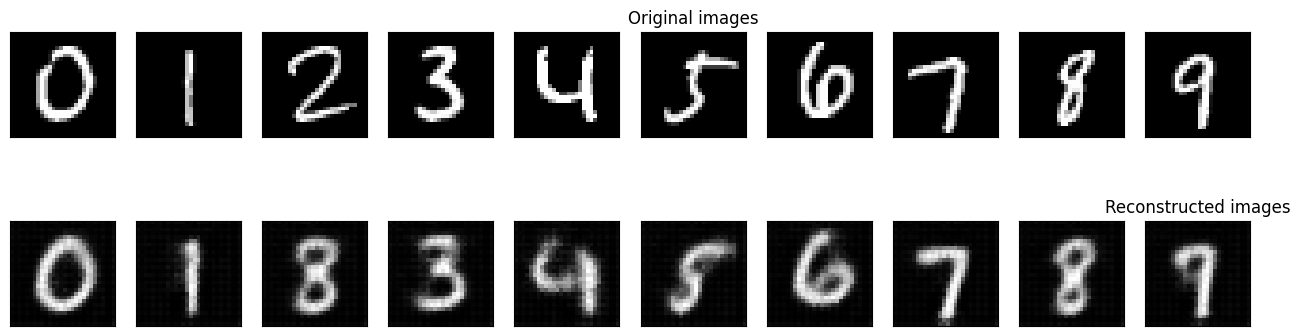

Iteration  0
	 partial train loss (single batch): 8381.656250
Iteration  60
	 partial train loss (single batch): 8364.138672

 EPOCH 15/50 	 train loss 31.940 	 val loss 31.985


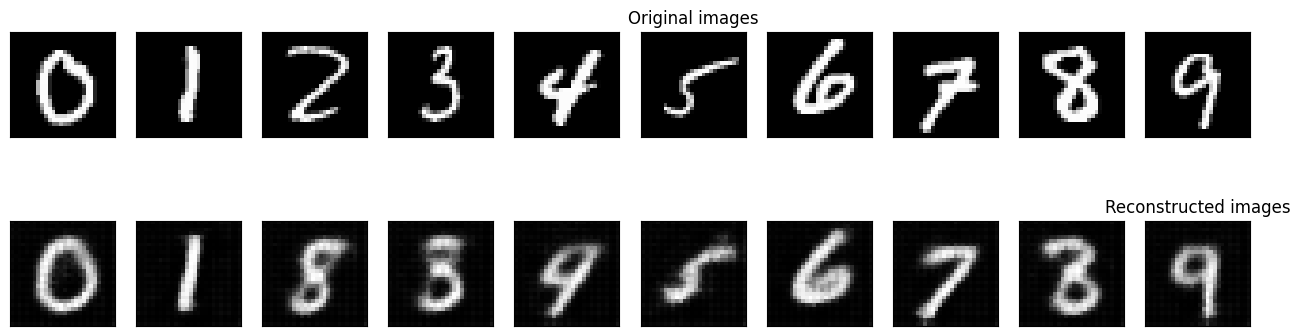

Iteration  0
	 partial train loss (single batch): 8269.702148
Iteration  60
	 partial train loss (single batch): 8250.305664

 EPOCH 16/50 	 train loss 31.712 	 val loss 31.825


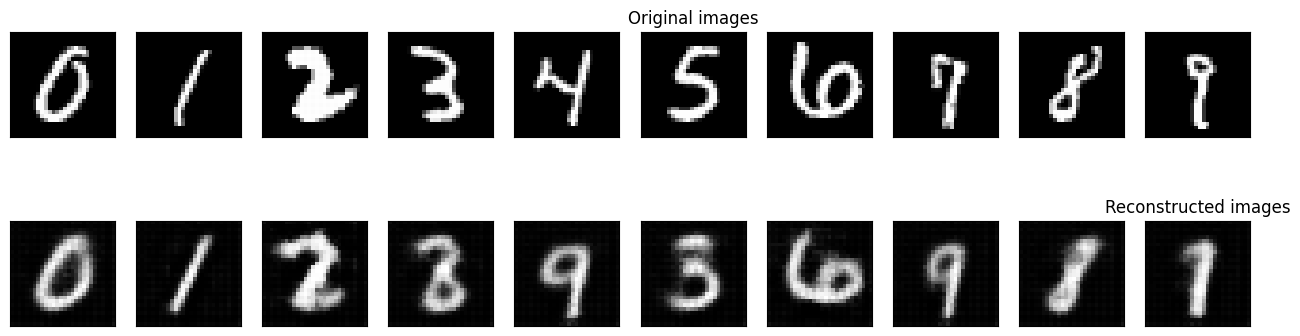

Iteration  0
	 partial train loss (single batch): 8194.669922
Iteration  60
	 partial train loss (single batch): 8204.412109

 EPOCH 17/50 	 train loss 31.567 	 val loss 31.686


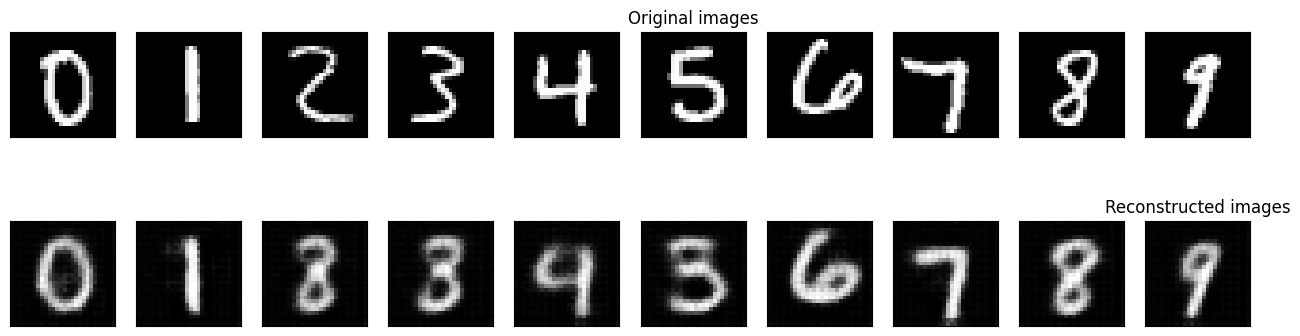

Iteration  0
	 partial train loss (single batch): 8226.643555
Iteration  60
	 partial train loss (single batch): 8165.332031

 EPOCH 18/50 	 train loss 31.446 	 val loss 31.614


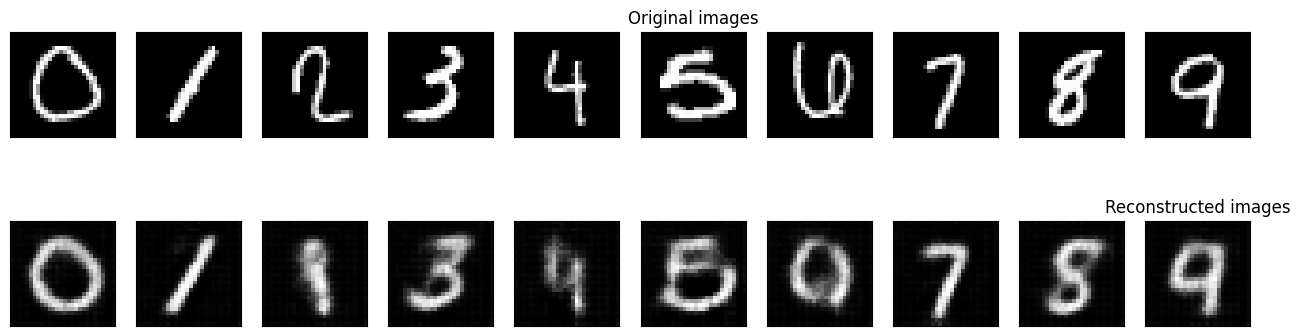

Iteration  0
	 partial train loss (single batch): 8216.876953
Iteration  60
	 partial train loss (single batch): 8181.579590

 EPOCH 19/50 	 train loss 31.299 	 val loss 31.495


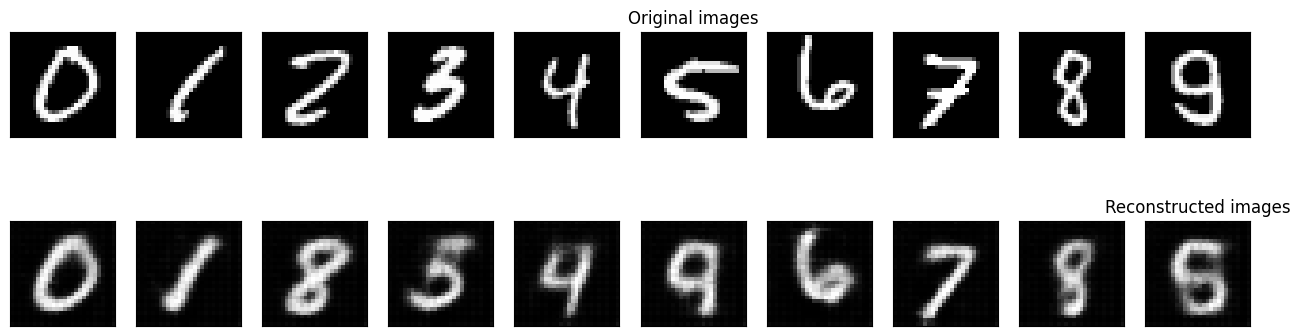

Iteration  0
	 partial train loss (single batch): 8172.298828
Iteration  60
	 partial train loss (single batch): 8127.515137

 EPOCH 20/50 	 train loss 31.192 	 val loss 31.418


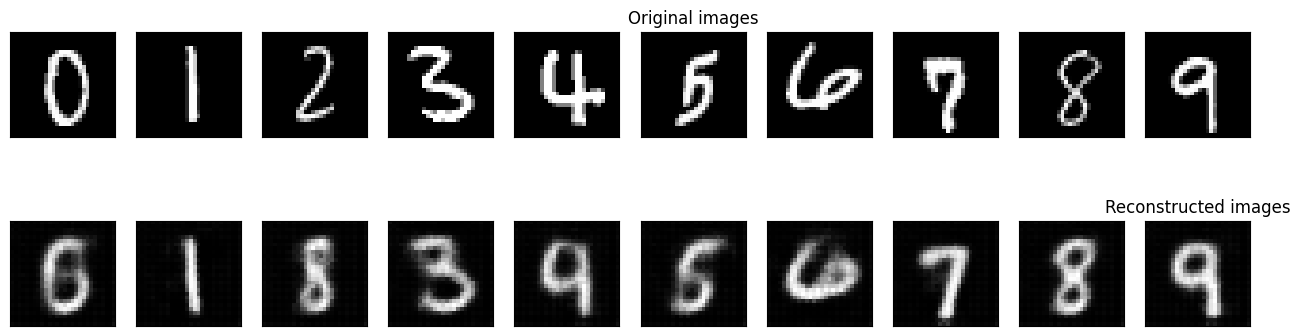

Iteration  0
	 partial train loss (single batch): 8183.083008
Iteration  60
	 partial train loss (single batch): 8100.720703

 EPOCH 21/50 	 train loss 31.100 	 val loss 31.255


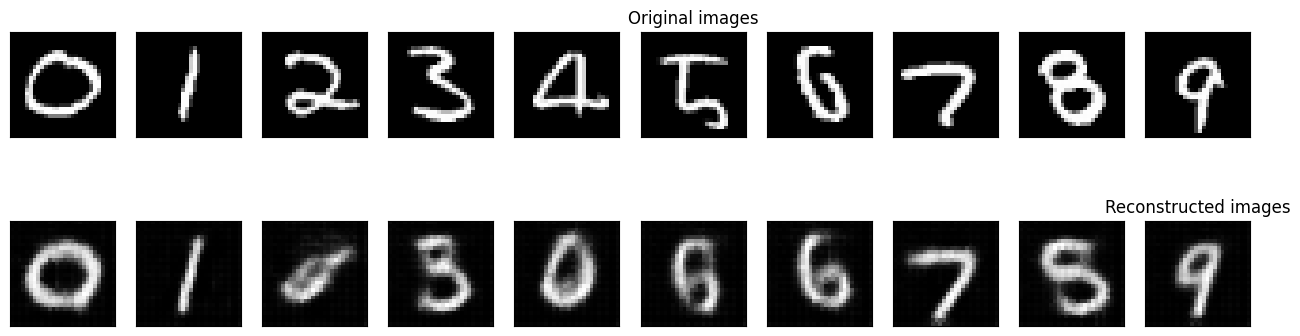

Iteration  0
	 partial train loss (single batch): 8068.931641
Iteration  60
	 partial train loss (single batch): 8084.679688

 EPOCH 22/50 	 train loss 31.003 	 val loss 31.119


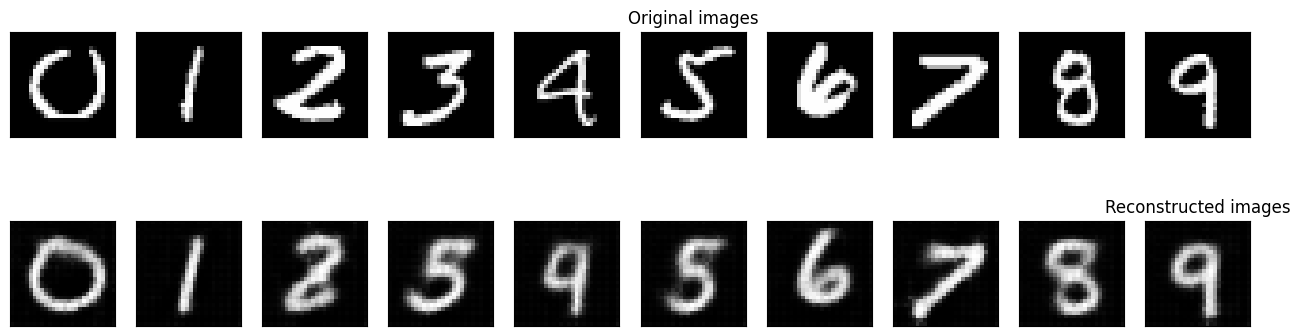

Iteration  0
	 partial train loss (single batch): 8080.710449
Iteration  60
	 partial train loss (single batch): 8079.776855

 EPOCH 23/50 	 train loss 30.917 	 val loss 31.282


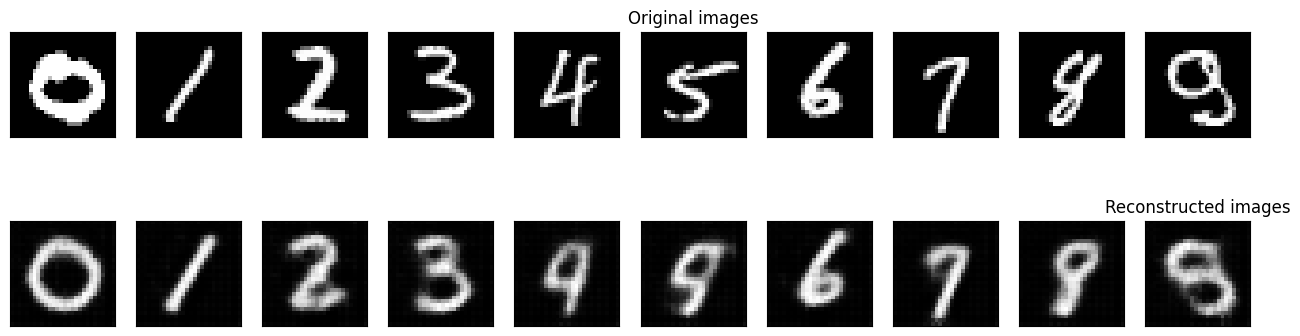

Iteration  0
	 partial train loss (single batch): 8074.045898
Iteration  60
	 partial train loss (single batch): 8031.545898

 EPOCH 24/50 	 train loss 30.848 	 val loss 31.066


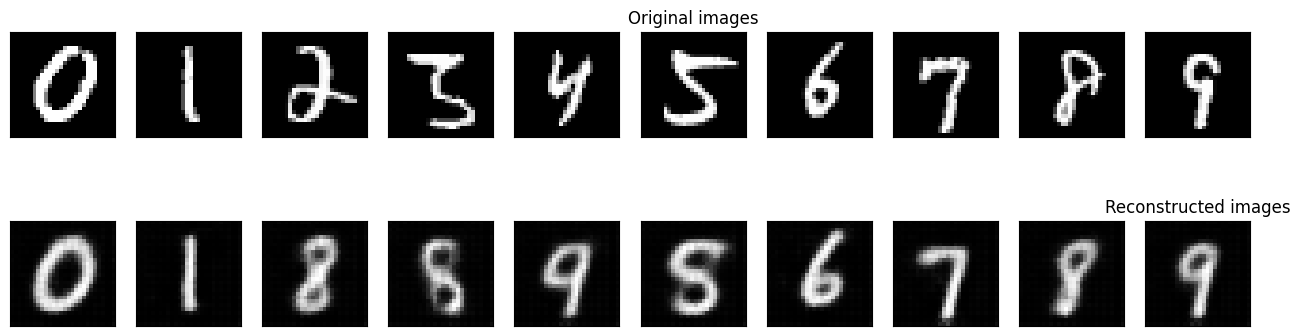

Iteration  0
	 partial train loss (single batch): 8002.292969
Iteration  60
	 partial train loss (single batch): 7976.999023

 EPOCH 25/50 	 train loss 30.762 	 val loss 31.031


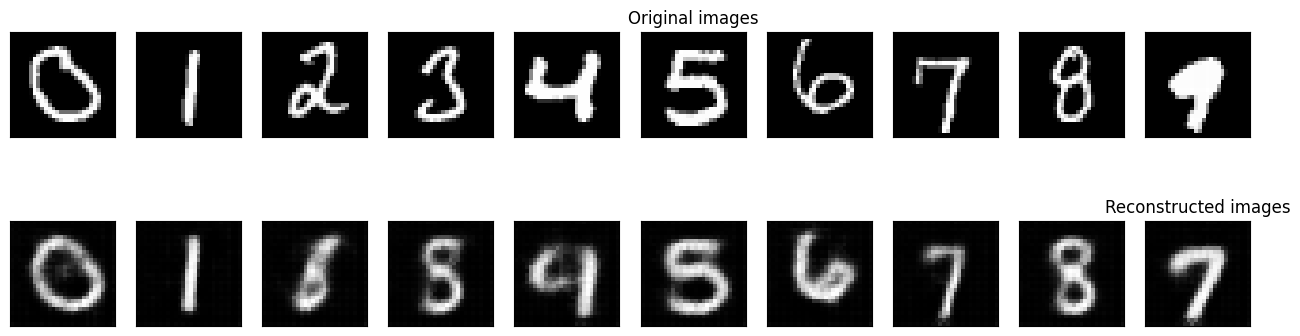

Iteration  0
	 partial train loss (single batch): 8032.168457
Iteration  60
	 partial train loss (single batch): 7986.820801

 EPOCH 26/50 	 train loss 30.705 	 val loss 31.045


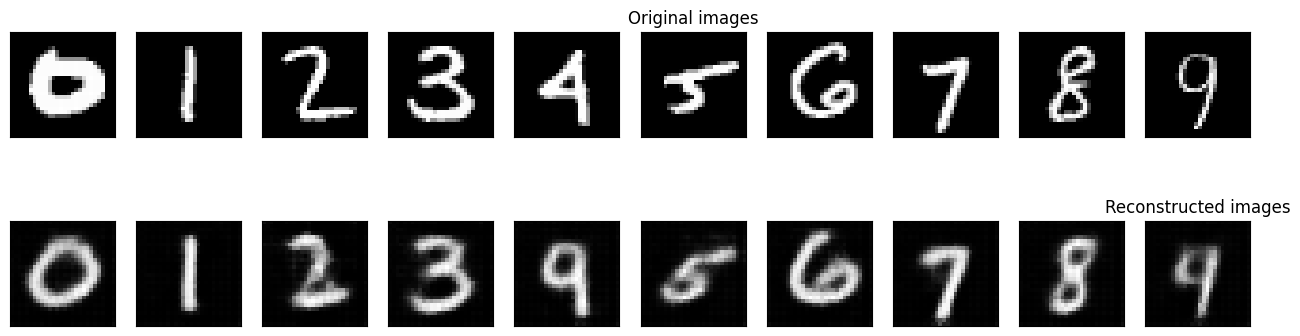

Iteration  0
	 partial train loss (single batch): 8012.632812
Iteration  60
	 partial train loss (single batch): 8015.256836

 EPOCH 27/50 	 train loss 30.604 	 val loss 31.022


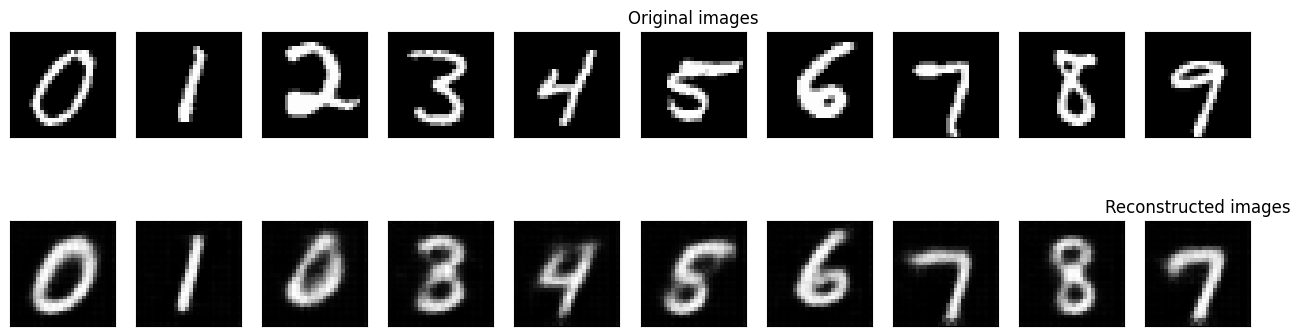

Iteration  0
	 partial train loss (single batch): 7960.654297
Iteration  60
	 partial train loss (single batch): 7908.896484

 EPOCH 28/50 	 train loss 30.510 	 val loss 30.951


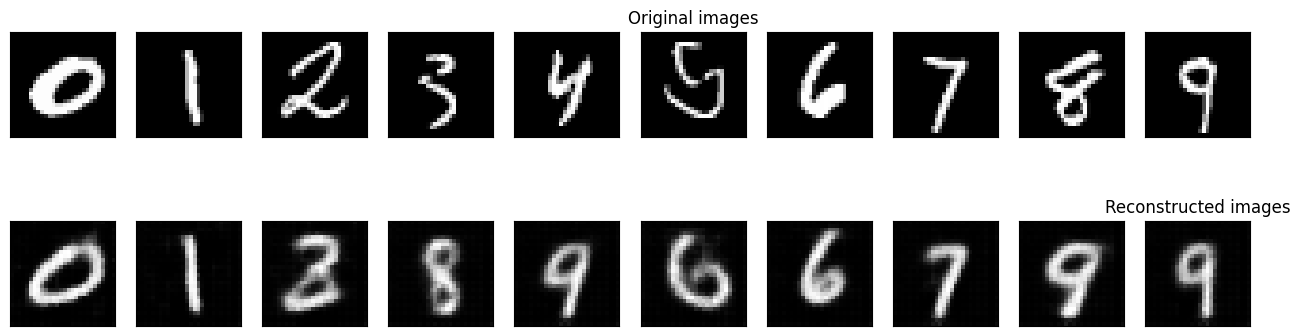

Iteration  0
	 partial train loss (single batch): 7931.921387
Iteration  60
	 partial train loss (single batch): 7942.480469

 EPOCH 29/50 	 train loss 30.484 	 val loss 30.985


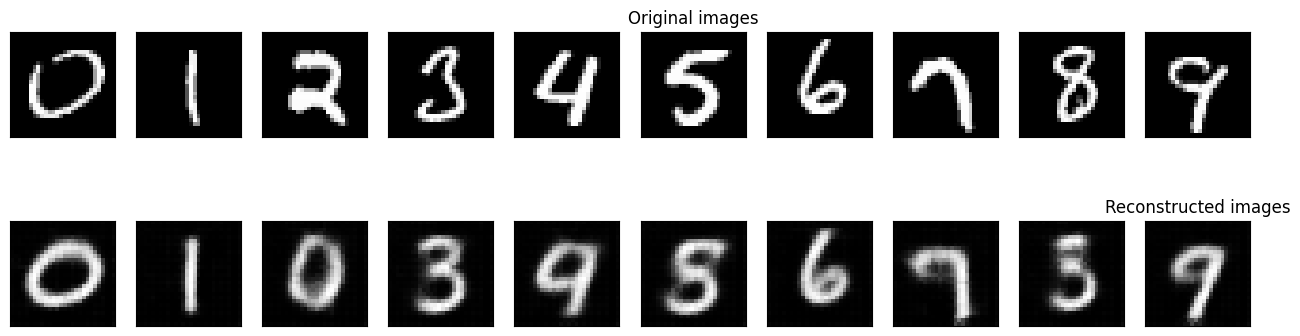

Iteration  0
	 partial train loss (single batch): 7917.924805
Iteration  60
	 partial train loss (single batch): 7945.701660

 EPOCH 30/50 	 train loss 30.464 	 val loss 30.856


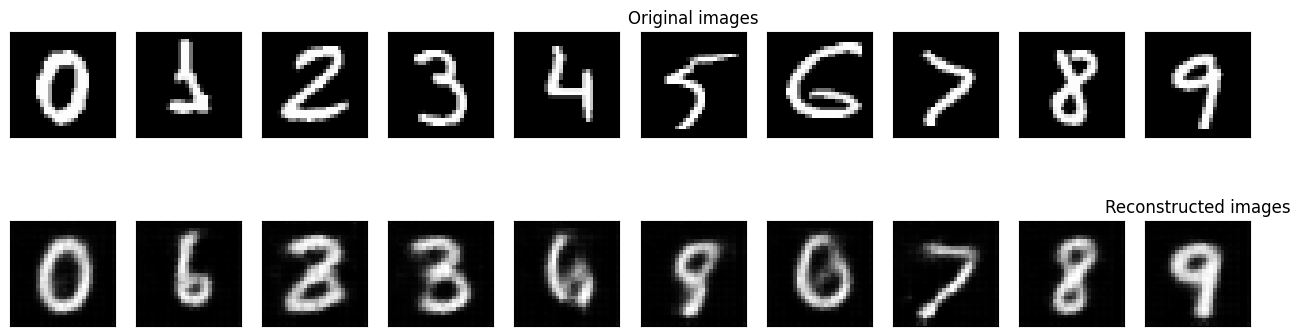

Iteration  0
	 partial train loss (single batch): 7962.185547
Iteration  60
	 partial train loss (single batch): 7968.923828

 EPOCH 31/50 	 train loss 30.414 	 val loss 30.807


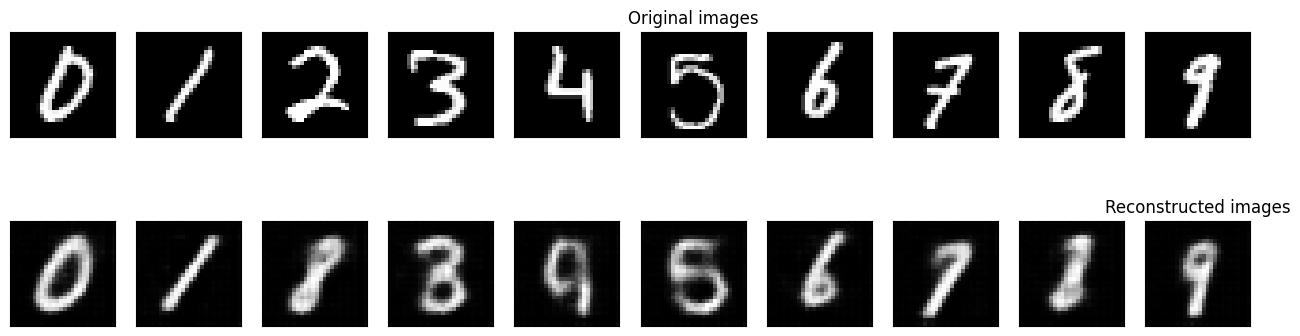

Iteration  0
	 partial train loss (single batch): 7957.524414
Iteration  60
	 partial train loss (single batch): 7944.641602

 EPOCH 32/50 	 train loss 30.326 	 val loss 30.763


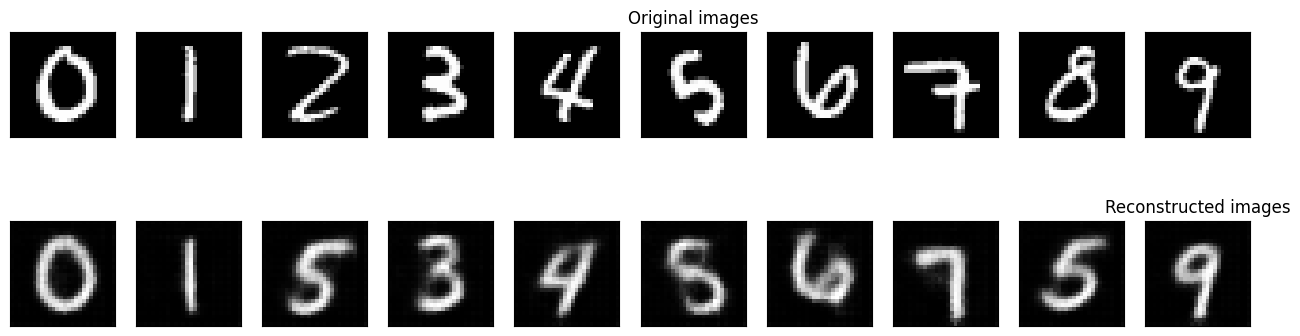

Iteration  0
	 partial train loss (single batch): 7896.082031
Iteration  60
	 partial train loss (single batch): 7901.092285

 EPOCH 33/50 	 train loss 30.281 	 val loss 30.672


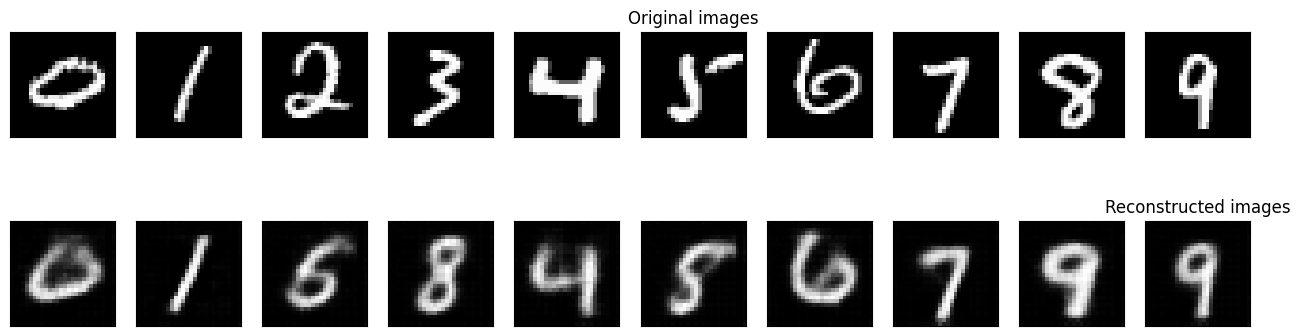

Iteration  0
	 partial train loss (single batch): 7863.166016
Iteration  60
	 partial train loss (single batch): 7888.863281

 EPOCH 34/50 	 train loss 30.228 	 val loss 30.763


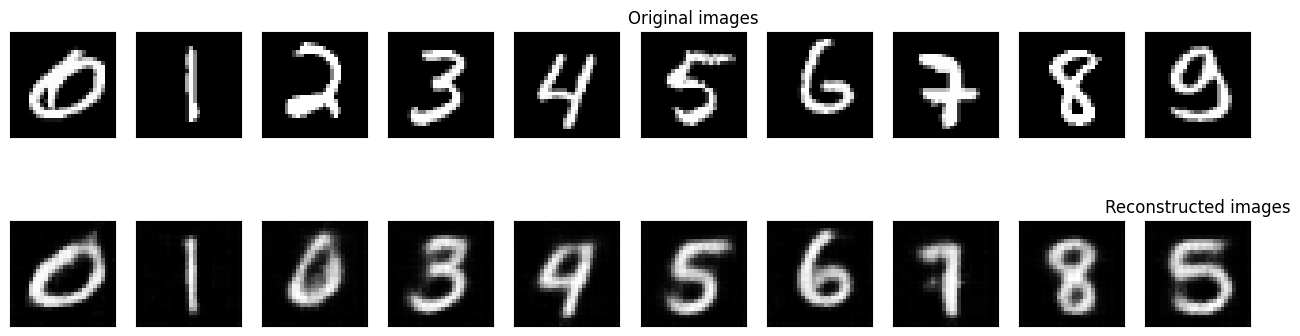

Iteration  0
	 partial train loss (single batch): 7882.872559
Iteration  60
	 partial train loss (single batch): 7841.978516

 EPOCH 35/50 	 train loss 30.187 	 val loss 30.703


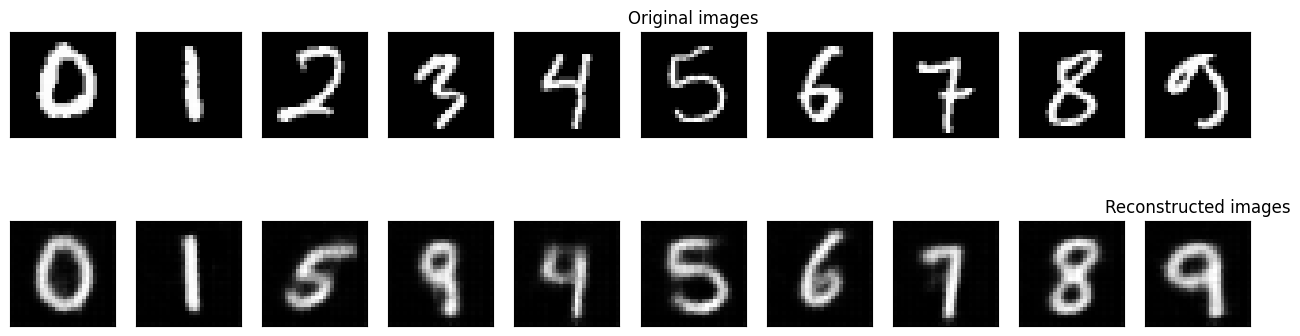

Iteration  0
	 partial train loss (single batch): 7862.693848
Iteration  60
	 partial train loss (single batch): 7896.964355

 EPOCH 36/50 	 train loss 30.134 	 val loss 30.585


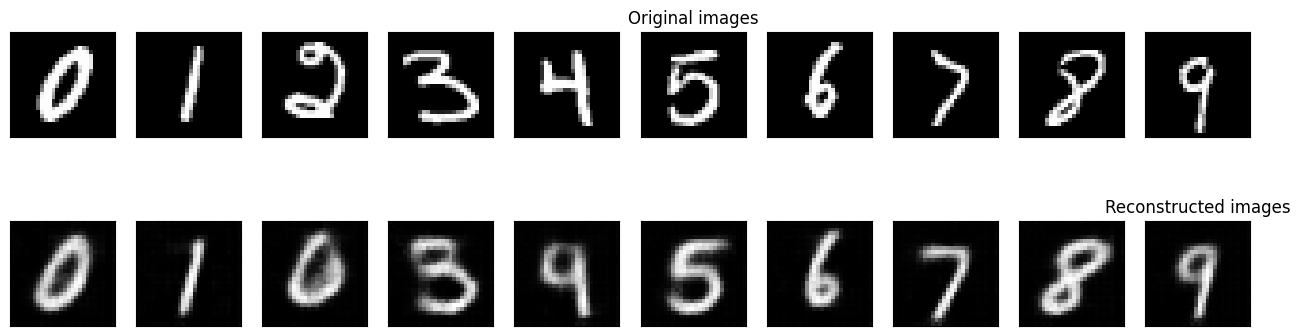

Iteration  0
	 partial train loss (single batch): 7870.071289
Iteration  60
	 partial train loss (single batch): 7852.820801

 EPOCH 37/50 	 train loss 30.065 	 val loss 30.479


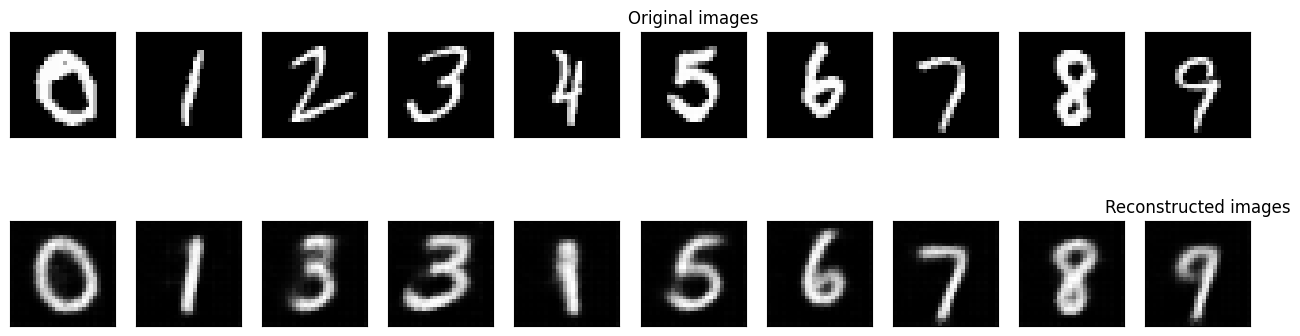

Iteration  0
	 partial train loss (single batch): 7852.008301
Iteration  60
	 partial train loss (single batch): 7884.669922

 EPOCH 38/50 	 train loss 30.068 	 val loss 30.439


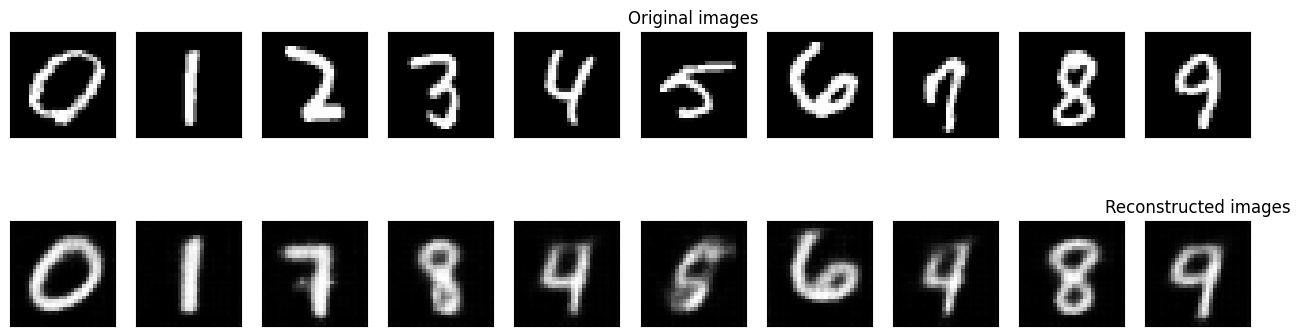

Iteration  0
	 partial train loss (single batch): 7791.955566
Iteration  60
	 partial train loss (single batch): 7827.719238

 EPOCH 39/50 	 train loss 30.002 	 val loss 30.469


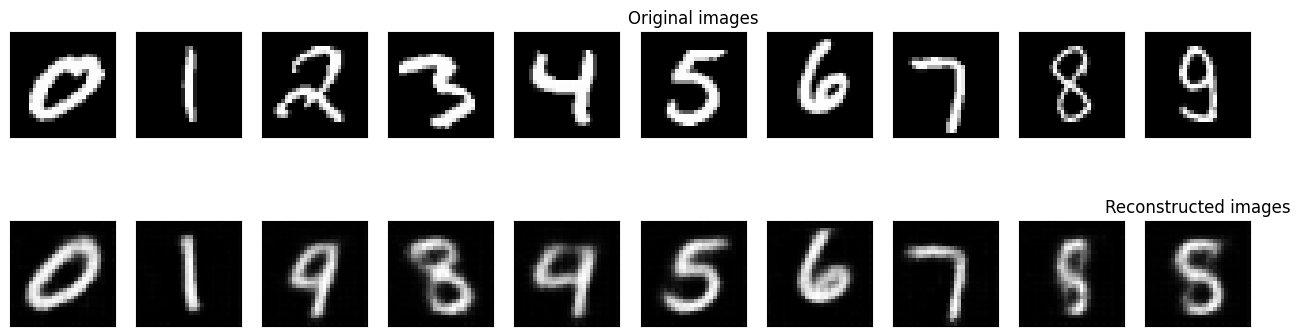

Iteration  0
	 partial train loss (single batch): 7744.461914
Iteration  60
	 partial train loss (single batch): 7897.606445

 EPOCH 40/50 	 train loss 30.009 	 val loss 30.442


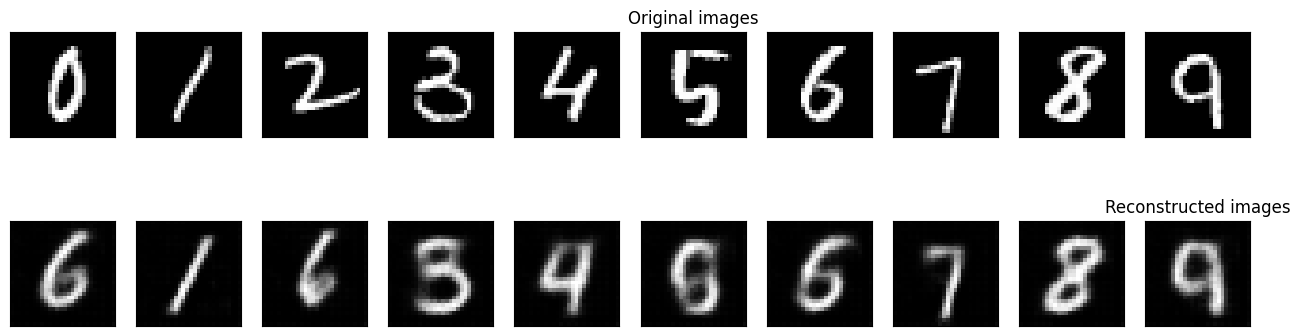

Iteration  0
	 partial train loss (single batch): 7795.893555
Iteration  60
	 partial train loss (single batch): 7819.767578

 EPOCH 41/50 	 train loss 29.933 	 val loss 30.415


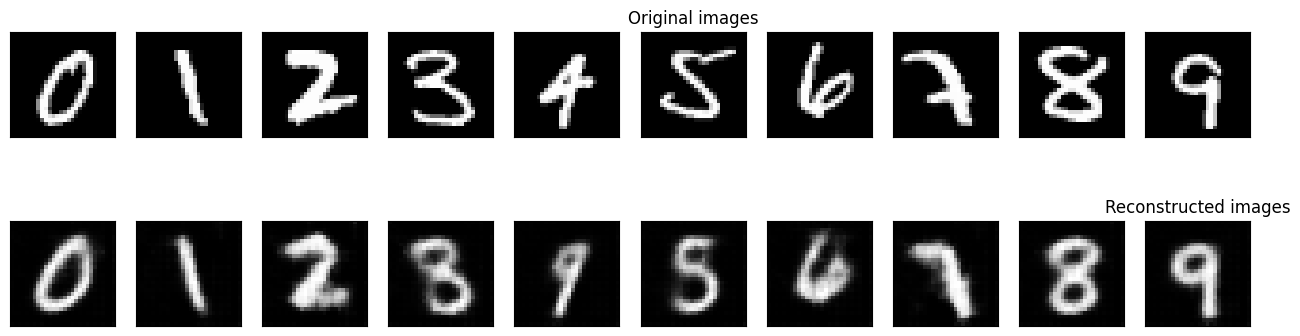

Iteration  0
	 partial train loss (single batch): 7786.096680
Iteration  60
	 partial train loss (single batch): 7798.962402

 EPOCH 42/50 	 train loss 29.897 	 val loss 30.337


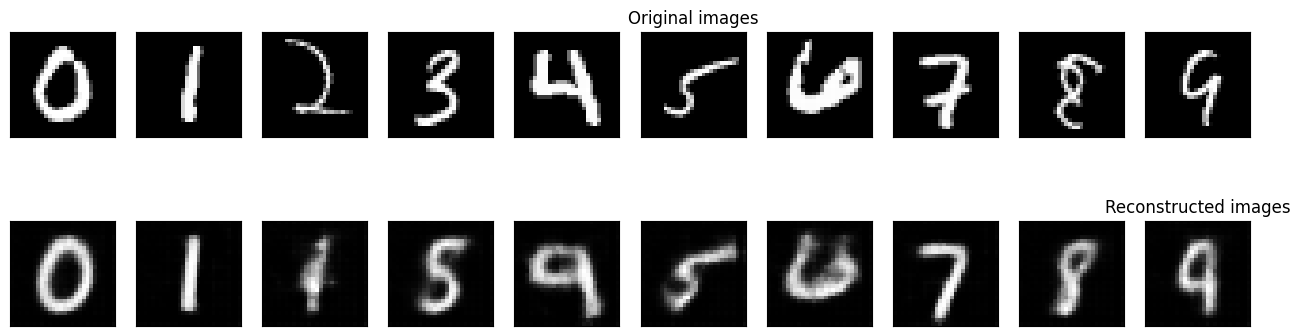

Iteration  0
	 partial train loss (single batch): 7661.625977
Iteration  60
	 partial train loss (single batch): 7854.949219

 EPOCH 43/50 	 train loss 29.894 	 val loss 30.314


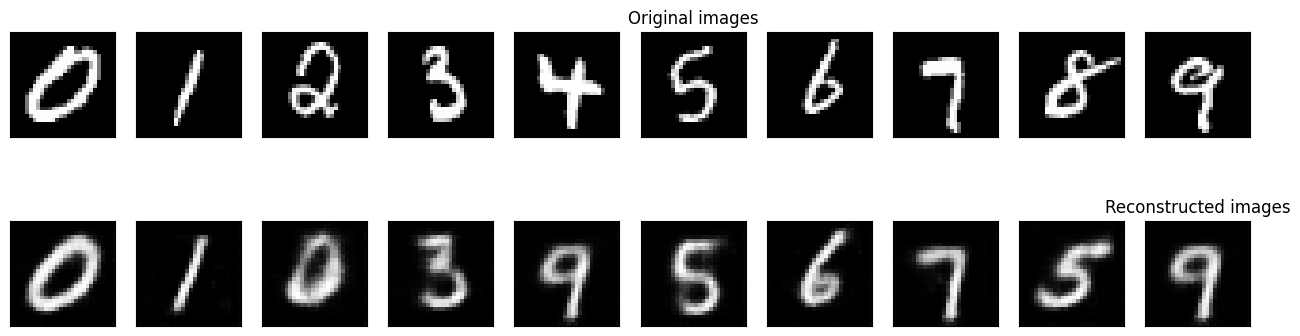

Iteration  0
	 partial train loss (single batch): 7770.742188
Iteration  60
	 partial train loss (single batch): 7771.960938

 EPOCH 44/50 	 train loss 29.830 	 val loss 30.304


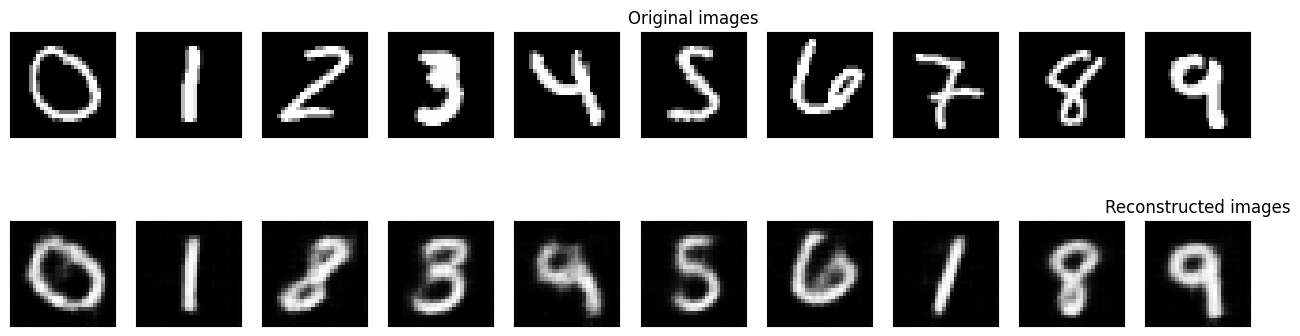

Iteration  0
	 partial train loss (single batch): 7710.645508
Iteration  60
	 partial train loss (single batch): 7713.823242

 EPOCH 45/50 	 train loss 29.790 	 val loss 30.322


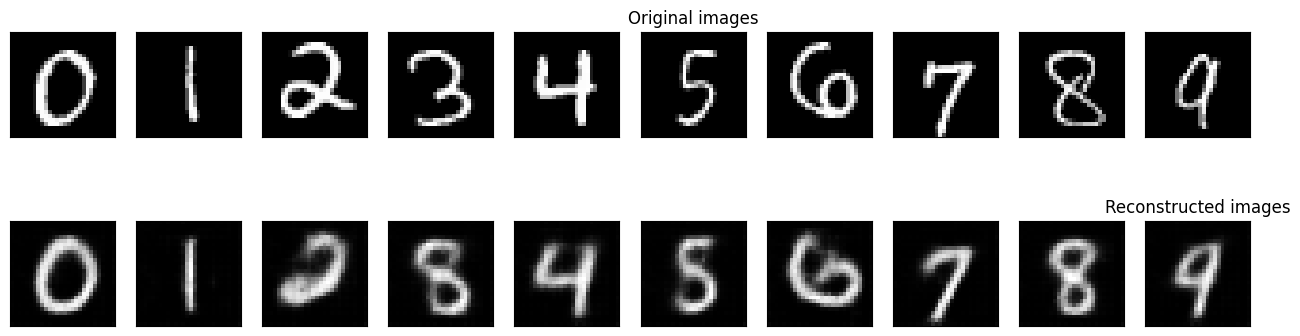

Iteration  0
	 partial train loss (single batch): 7736.948242
Iteration  60
	 partial train loss (single batch): 7833.596680

 EPOCH 46/50 	 train loss 29.778 	 val loss 30.255


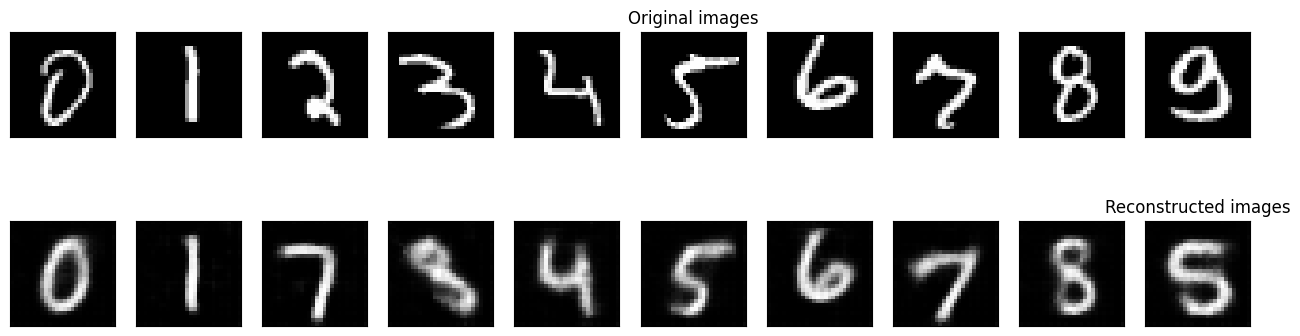

Iteration  0
	 partial train loss (single batch): 7718.919922
Iteration  60
	 partial train loss (single batch): 7743.963379

 EPOCH 47/50 	 train loss 29.737 	 val loss 30.276


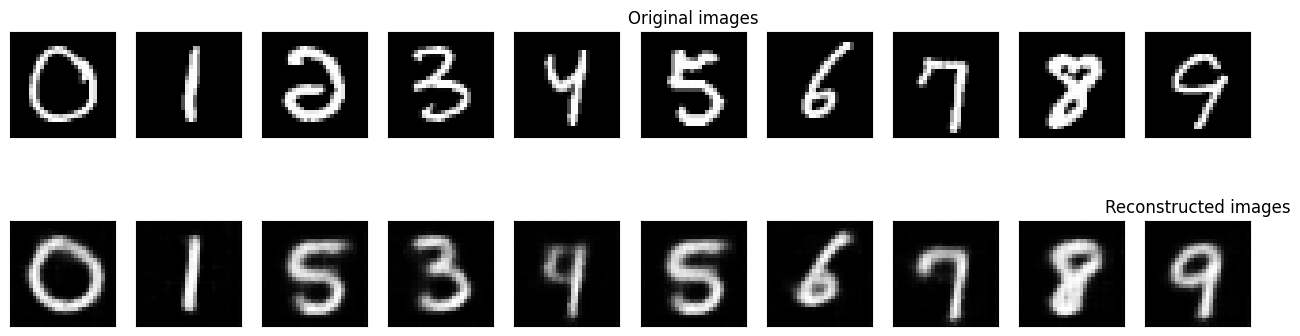

Iteration  0
	 partial train loss (single batch): 7697.030762
Iteration  60
	 partial train loss (single batch): 7774.566406

 EPOCH 48/50 	 train loss 29.719 	 val loss 30.268


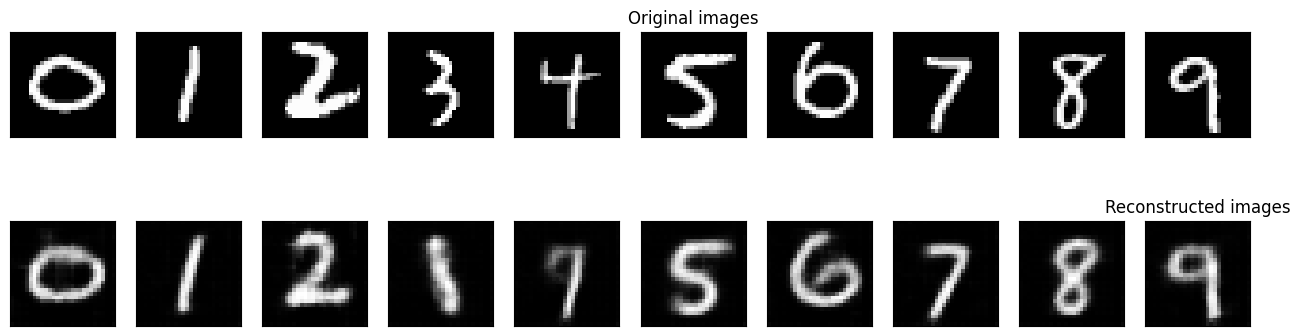

Iteration  0
	 partial train loss (single batch): 7708.367188
Iteration  60
	 partial train loss (single batch): 7720.379883

 EPOCH 49/50 	 train loss 29.681 	 val loss 30.205


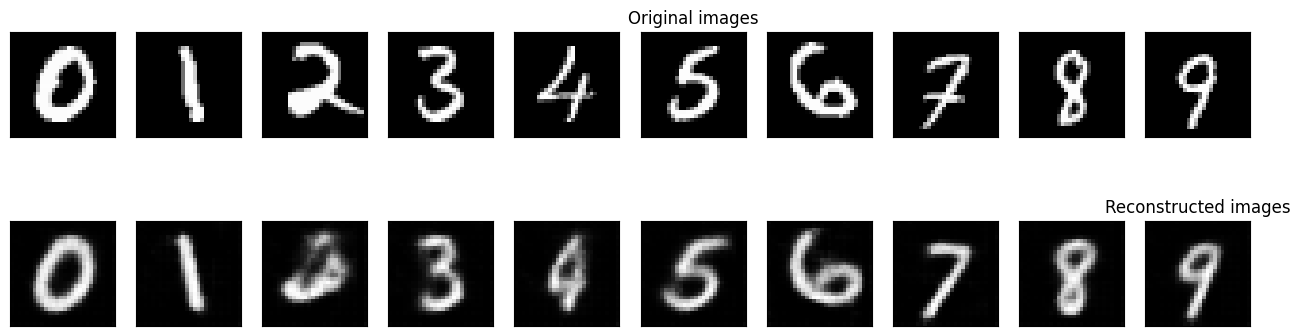

Iteration  0
	 partial train loss (single batch): 7671.200684
Iteration  60
	 partial train loss (single batch): 7754.157227

 EPOCH 50/50 	 train loss 29.683 	 val loss 30.157


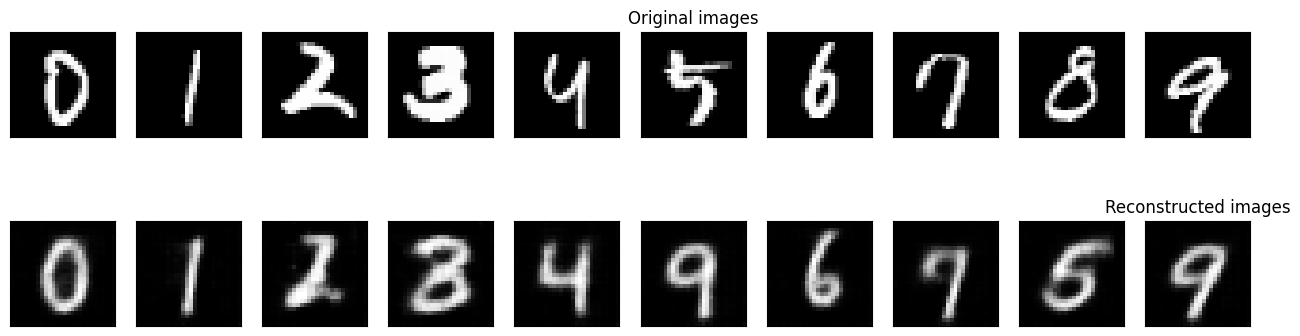

In [19]:
num_epochs = 50

for epoch in range(num_epochs):
    train_loss = train_epoch(vae,device,train_loader,optim)
    val_loss = test_epoch(vae,device,valid_loader)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    plot_ae_outputs(vae.encoder,vae.decoder,n=10)

# Data Generator

In [20]:
def generate_data(data_set, cls):
    targets = data_set.targets
    sizee = len(np.where(targets==cls)[0])
    idx = np.where(targets==cls)[0][np.random.randint(sizee, size=1)[0]]
    img = data_set[idx][0].unsqueeze(0).to(device)
    vae.encoder.eval()
    vae.decoder.eval()
    with torch.no_grad():
        rec_img  = vae.decoder(vae.encoder(img))
    rec_img = rec_img*255
    orignal_image = img.squeeze().cpu()
    rec_img = rec_img.to(torch.int).squeeze(0).cpu()
    return rec_img, orignal_image

Distribution of classes in Imbalanced dataset:
Counter({7: 5639, 1: 5154, 9: 3714, 5: 3453, 0: 2963, 6: 2932, 8: 2697, 4: 1785, 3: 877, 2: 526})


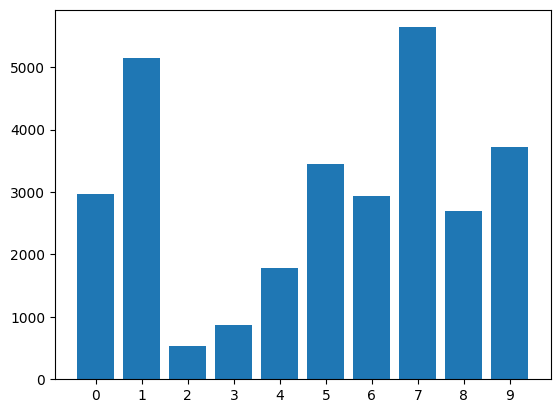

In [21]:
print('Distribution of classes in Imbalanced dataset:')
print(Counter(imbalanced_train_loader.dataset.targets.numpy()))
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_train_loader.dataset.targets, return_counts=True)
ax.bar(range(10), counts)
ax.set_xticks(range(10))
plt.show()

# Finding Dominant Class in Imbalanced Dataset

In [22]:
 def find_dominant_class(imbalanced_train_loader):
    class_distibution = Counter(imbalanced_train_loader.dataset.targets.numpy())
    dominant_class_num = 0
    for i in class_distibution:
        if class_distibution[i] > dominant_class_num:
            dominant_class_num = class_distibution[i]

    return dominant_class_num, class_distibution

# Start Appending Data To Imbalanced Dataset

In [23]:
dominant_class_num, class_distibution = find_dominant_class(imbalanced_train_loader)

for i in class_distibution:
    print("======"*10)
    print("\nCreating Data for Class: ", i)
    print("======"*10)
    generate_samples = int(dominant_class_num - class_distibution[i])
    for j in range(generate_samples):
        if j%500 == 0:
            print(j," Samples created...")
        synthetic_image, orignal_image = generate_data(imbalanced_train_dataset, i)
        pred = synthetic_image
        gt = orignal_image
        imbalanced_train_dataset.targets = torch.tensor(np.append(imbalanced_train_dataset.targets, [i],axis=0))
        imbalanced_train_dataset.data =  torch.tensor(np.append(imbalanced_train_dataset.data, synthetic_image.to(torch.uint8),axis=0))


imbalanced_train_dataset_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1302,), (0.3069,))
])
imbalanced_train_dataset.transform = imbalanced_train_dataset_transform
imbalanced_train_loader = torch.utils.data.DataLoader(imbalanced_train_dataset, batch_size=128, shuffle=True)


Creating Data for Class:  5
0  Samples created...
500  Samples created...
1000  Samples created...
1500  Samples created...
2000  Samples created...

Creating Data for Class:  0
0  Samples created...
500  Samples created...
1000  Samples created...
1500  Samples created...
2000  Samples created...
2500  Samples created...

Creating Data for Class:  1
0  Samples created...

Creating Data for Class:  9
0  Samples created...
500  Samples created...
1000  Samples created...
1500  Samples created...

Creating Data for Class:  3
0  Samples created...
500  Samples created...
1000  Samples created...
1500  Samples created...
2000  Samples created...
2500  Samples created...
3000  Samples created...
3500  Samples created...
4000  Samples created...
4500  Samples created...

Creating Data for Class:  6
0  Samples created...
500  Samples created...
1000  Samples created...
1500  Samples created...
2000  Samples created...
2500  Samples created...

Creating Data for Class:  7

Creating Data for C

# Bar Plot Synthetic Balanced Dataset

Distribution of classes in Imbalanced dataset:
Counter({5: 5639, 0: 5639, 1: 5639, 9: 5639, 3: 5639, 6: 5639, 7: 5639, 8: 5639, 4: 5639, 2: 5639})


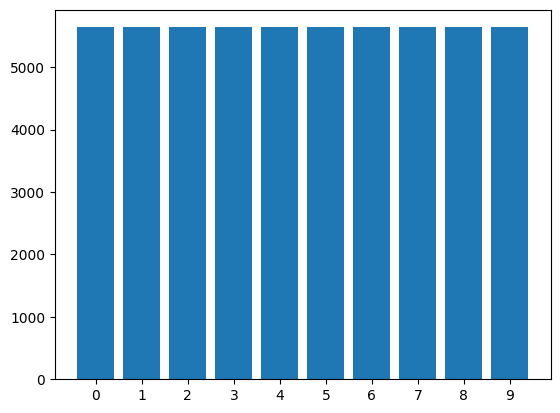

In [24]:
train_transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1302,), (0.3069,))])

test_transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1302,), (0.3069,))])

imbalanced_train_dataset.transform = train_transform
test_ds.transform = test_transform

train_dataloader = torch.utils.data.DataLoader(imbalanced_train_dataset, batch_size=128, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=500, shuffle=True)

print('Distribution of classes in Imbalanced dataset:')
print(Counter(imbalanced_train_loader.dataset.targets.numpy()))
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_train_loader.dataset.targets, return_counts=True)
ax.bar(range(10), counts)
ax.set_xticks(range(10))
plt.show()

# Train the above model like done earlier and print test data performance


In [25]:
model = train(imbalanced_train_loader, ConvNet(), epochs=1)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 0 [0/441 (0%)]	 training loss: 2.319731
epoch: 0 [10/441 (2%)]	 training loss: 2.132575
epoch: 0 [20/441 (5%)]	 training loss: 1.707139
epoch: 0 [30/441 (7%)]	 training loss: 1.349721
epoch: 0 [40/441 (9%)]	 training loss: 0.877624
epoch: 0 [50/441 (11%)]	 training loss: 0.758870
epoch: 0 [60/441 (14%)]	 training loss: 0.822819
epoch: 0 [70/441 (16%)]	 training loss: 0.683159
epoch: 0 [80/441 (18%)]	 training loss: 0.717483
epoch: 0 [90/441 (20%)]	 training loss: 0.583464
epoch: 0 [100/441 (23%)]	 training loss: 0.515607
epoch: 0 [110/441 (25%)]	 training loss: 0.618601
epoch: 0 [120/441 (27%)]	 training loss: 0.743763
epoch: 0 [130/441 (29%)]	 training loss: 0.620496
epoch: 0 [140/441 (32%)]	 training loss: 0.623112
epoch: 0 [150/441 (34%)]	 training loss: 0.767085
epoch: 0 [160/441 (36%)]	 training loss: 0.655690
epoch: 0 [170/441 (39%)]	 training loss: 0.732188
epoch: 0 [180/441 (41%)]	 training loss: 0.499514
epoch: 0 [190/441 (43%)]	 training loss: 0.642204
epoch: 0 [200/44

In [28]:
test_acc, cf = test(model)
percentages2 = get_class_percentages(cf)
print("test accuracy : ", str(test_acc))

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)



Test dataset: Overall Loss: 0.2982, Overall Accuracy: 9113/10000 (91%)

test accuracy :  91.13


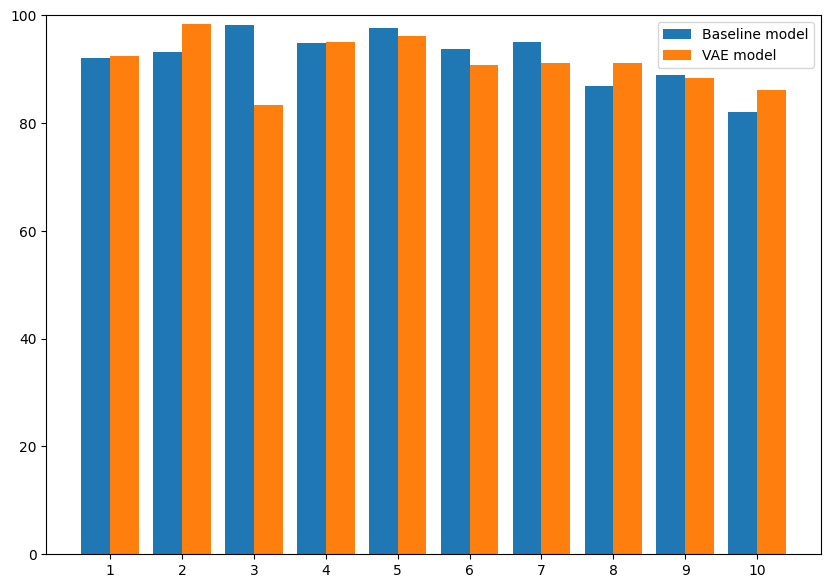

In [29]:
fig= plt.subplots(figsize=(10, 7))
br1 = np.arange(10)
br2 = [x + 0.4 for x in br1]
plt.bar(br1, np.char.strip(np.diagonal(percentages1), '%').astype(float), width = 0.4, label ='Baseline model')
plt.bar(br2, np.char.strip(np.diagonal(percentages2), '%').astype(float), width = 0.4, label ='VAE model')
plt.xticks([r + 0.2 for r in range(10)],
        ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
plt.ylim(0, 100)
plt.legend()
plt.show()